<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%86%D0%B5%D0%BD%D1%89%D0%B8%D0%BA%D0%B0_%D0%BF%D0%BE%D0%B7%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Использование оценщика позы

# Using the pose evaluator

В этом уроке мы сделаем помощник для тренировок, счётчик количества повторений упражнения.

In this lesson, we will make a training assistant, a counter for the number of repetitions of an exercise.

Модель ориентира может предсказывать расположение 33 ориентиров позы. К каждому ориентиру присваивается свой уникальный номер. 

The landmark model can predict the location of 33 pose landmarks. Each landmark is assigned a unique number.

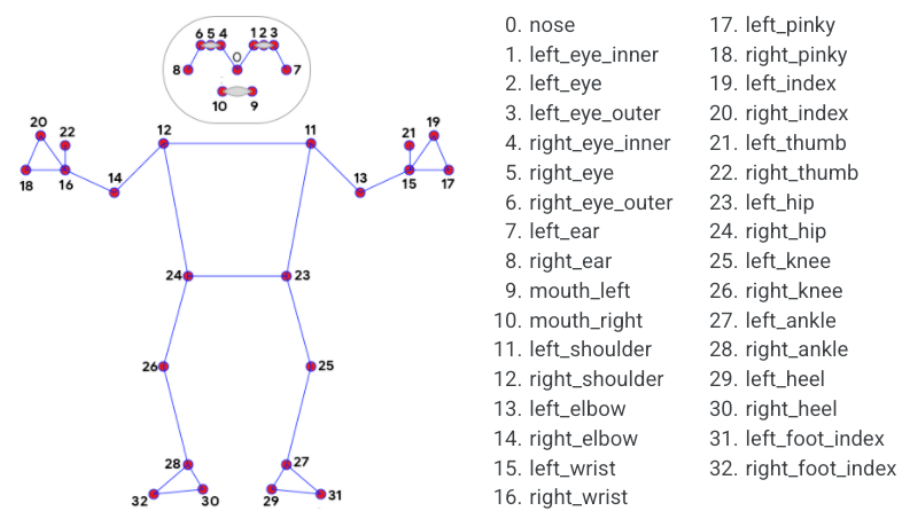

В этом уроке мы будем использовать точки рук.

In this tutorial we will use hand points.

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_49.Using_pose_estimator.zip
!unzip Lesson_49.Using_pose_estimator.zip
%cd /content/Using_pose_estimator

--2022-02-08 17:21:48--  http://dataudt.ru/datasets/cv/Lesson_49.Using_pose_estimator.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2880659 (2.7M) [application/zip]
Saving to: ‘Lesson_49.Using_pose_estimator.zip’

Lesson_49.Using_pos 100%[===================>]   2.75M  2.29MB/s    in 1.2s    

2022-02-08 17:21:50 (2.29 MB/s) - ‘Lesson_49.Using_pose_estimator.zip’ saved [2880659/2880659]

Archive:  Lesson_49.Using_pose_estimator.zip
  inflating: Using_pose_estimator/PersonalAITrainer.py  
  inflating: Using_pose_estimator/pose_tracking_full_body_landmarks.png  
  inflating: Using_pose_estimator/PoseModule.py  
   creating: Using_pose_estimator/Videos/
  inflating: Using_pose_estimator/Videos/biceps_1.mp4  
  inflating: Using_pose_estimator/Videos/biceps_2.mp4  
  inflating: Using_pose_estimator/Videos/biceps_3.mp4  
/content/Using_pose_estimator


Вновь  скачаем уже знакомую нам библиотеку.

Download the already familiar library again.

In [2]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.3 MB/s 


Ниже мы просто дублируем код с прошлого урока, создавая вновь класс **poseDetector**.

Below we simply duplicate the code from the previous lesson, creating again the **poseDetector** class.

In [3]:
# импортируем необходимые модули
# import the required modules
import cv2
import mediapipe as mp
import time
import imutils
import math

# создаём класс детектора позы тела человека
# create a human body pose detector class
class poseDetector():
    def __init__(self, mode=False, upBody=False, smooth=True, detectionCon=0.5, trackCon=0.5):
        # режим работы
        # operating mode
        self.mode = mode
        # отображать точки всего тела или только верхней части
        # display points of the whole body or just the upper part
        self.upBody = upBody
        # сглаживание отображения точек
        # smoothing the display of points
        self.smooth = smooth
        # значение достоверности обнаружения позы
        # value of the pose detection confidence
        self.detectionCon = detectionCon
        # значение достоверности отслеживания ориентиров
        # credibility value for landmark tracking
        self.trackCon = trackCon

        # инициазируем детектор позы mediapipe
        # initiate the mediapipe pose detector
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(self.mode,
                                    self.upBody,
                                    self.smooth,
                                    self.detectionCon,
                                    self.trackCon)

        # инструменты для отрисовки сети ориентиров
        # tools for drawing a network of landmarks
        self.mpDraw = mp.solutions.drawing_utils

    # находим и рисуем сеть ориентиров
    # find and draw a network of landmarks
    def findPose(self, img, draw=True):
        # opencv по умолчанию сохраняет изображения
        # в формате каналов цвета BGR
        # конвертируем в стандартный формат RGB
        # opencv saves images by default
        # in BGR color channel format
        # convert to standard RGB format
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # детектор обрабатывает изображение и возвращает нам результат
        # нам не нужно дополнительно ничего знать, всё сделает за нас библиотека
        # the detector processes the image and returns the result to us
        # we don't need to know anything additionally, the library will do everything for us
        self.results = self.pose.process(imgRGB)

        # если мы обнаружили тело человека
        # if we found a human body
        if self.results.pose_landmarks:
            if draw:
                # рисуем точки и соединения на изображении
                # draw points and connections on the image
                self.mpDraw.draw_landmarks(img, self.results.pose_landmarks, self.mpPose.POSE_CONNECTIONS)

        # возвращаем изображение с нарисованной сетью ориентиров
        # return an image with a drawn grid of landmarks
        return img

    # находим координаты каждой точки на сети
    # find the coordinates of each point on the network
    def findPosition(self, img, draw=True):

        # создаём список координат
        # create a list of coordinates
        self.lmList = []

        # если обнаружили тело человека
        #if a human body is found
        if self.results.pose_landmarks:
            # берём каждую точку на ориентирах от 0 до 32
            # take each point on landmarks from 0 to 32
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                # и выведем номер и координаты каждой точки
                # and display the number and coordinates of each point

                # каждая точка имеет id и 3 координаты x, y и z
                # координаты нормированы  от 0 до 1
                # относительно ширины и высоты изображения
                # each point has an id and 3 coordinates x, y and z
                # coordinates are normalized from 0 to 1
                # relative to image width and height

                # высота, ширина и количество каналов изображения
                # height, width and number of image channels
                h, w, с = img.shape

                # чтобы получить координаты в пикселях умножим их
                # на ширину и высоту изображения соответственно
                # to get coordinates in pixels we multiply them
                # for the width and height of the image, respectively
                cx, cy = int(lm.x * w), int(lm.y * h)

                # добавляем координаты в список
                # add coordinates to the list
                self.lmList.append([id, cx, cy])

                # рисуем каждую точку
                # draw each point
                if draw:
                    cv2.circle(img, (cx, cy), 7, (255, 0, 0), cv2.FILLED)

        # возвращаем список координат
        # return a list of coordinates
        return self.lmList
    
    # находим угол для заданных точек
    # find the angle for the given points
    def findAngle(self, img, p1, p2, p3, draw=True):
 
        # присваиваем координаты необходимых точек
        # assign the coordinates of the required points
        x1, y1 = self.lmList[p1][1:]
        x2, y2 = self.lmList[p2][1:]
        x3, y3 = self.lmList[p3][1:]
 
        # расчитываем угол между двух линий
        # math.atan2 возвращвет значение угла в радианах
        # чтобы конвертировать радианы в углы
        # используем math.degrees
        # calculate the angle between two lines
        # math.atan2 returns the angle in radians
        # to convert radians to angles
        # use math.degrees
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) -
                             math.atan2(y1 - y2, x1 - x2))
        
        # если угол отрицательный,
        # то прибавляем 360 градусов
        # if the angle is negative,
        # then add 360 degrees
        if angle < 0:
            angle += 360
 
        # рисуем угол
        # draw the corner
        if draw:
            # рисуем соединяющие линии
            # draw connecting lines
            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 3)
            # рисуем точки
            # draw dots
            cv2.circle(img, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (0, 0, 255), 2)
            cv2.circle(img, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (0, 0, 255), 2)
            cv2.circle(img, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (0, 0, 255), 2)
            # отображаем значение угла
            # display the angle value
            cv2.putText(img, str(int(angle)), (x2 - 50, y2 + 50),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        
        # возвращаем расчитанный угол
        # return the calculated angle
        return angle


А здесь уже начинается новая часть.

And here the new part already begins.

In [4]:
# импортируем необходимые модули
# import the required modules
import cv2
import numpy as np
import time

In [5]:

 
# устанавливаем путь для захвата видео с файла
# set the path for capturing video from the file
cap = cv2.VideoCapture("Videos/biceps_3.mp4")
 
# инициализируем детектор позы
# initialize the pose detector
detector = poseDetector()

# счётчик количества повторений упражнения
# counter of the number of repetitions of the exercise
count = 0

# направление движения
# 0 - вверх
# 1 - вниз
# direction of movement
# 0 - up
# 1 - down
dir = 0

# для расчёта fps
# to calculate fps
# предыдущее время 
# previous time
pTime = 0  

writer = None
# бесконечный цикл
# endless cycle
while True:
    # считываем изображение с видео
    # read image from video
    success, img = cap.read()
    # если success = False, то выходим из цикла 
    # if success = False, then exit the loop
    if not success:
            break
    # для удобства уменьшаем размер изображения
    # for convenience, reduce the size of the image
    img = cv2.resize(img, (1280, 720))
    
    # передаём изображение с камеры детектору
    # обратно получаем изображение
    # с нарисованной сетью ориентиров
    # transfer the image from the camera to the detector
    # get the image back
    # with a drawn web of landmarks
    img = detector.findPose(img, False)
    # и список координат точек ориентиров
    # не рисуем все точки и линии позы
    # and list of coordinates of landmarks points
    # don't draw all the points and lines of the pose
    lmList = detector.findPosition(img, False)
    
    # если список точек не пустой
    # то есть обнаружина поза
    # if the list of points is not empty
    # that is, I found a pose
    if len(lmList) != 0:
        # задаём точки для подсчёта угла
        # set points for calculating the angle
        # правая рука
        # right hand
        # angle = detector.findAngle(img, 12, 14, 16)
        # левая рука
        # left hand
        angle = detector.findAngle(img, 11, 13, 15)
        
        # с помощью линейной интерполяции np.interp
        # конвертируем диапазон угла в проценты
        # using linear interpolation np.interp
        # convert angle range to percent
        per = np.interp(angle, (210, 310), (0, 100))
        # конвертируем диапазон угла в в длинну столбика
        # convert the angle range in to the length of the column
        bar = np.interp(angle, (220, 310), (650, 100))
 
        # считаем количество сделанных упражнений
        # учитывая направление движения
        # count the number of exercises done
        # considering the direction of movement
        color = (255, 0, 255)
        # если достигли верха 
        # if reached the top
        if per == 100: 
            color = (0, 255, 0)
            # и направлялись вверх 
            # and headed up
            if dir == 0: 
                # увеличиваем счётчик количества сделанных упражнений
                # и изменяем флаг направления движения
                # increase the counter of the number of exercises done
                # and change the flag of the direction of movement
                count += 0.5 
                dir = 1
        # если достигли низа 
        # if you hit the bottom
        if per == 0: 
            color = (0, 255, 0)
            # и двигались вниз 
            # and moved down
            if dir == 1: 
                # увеличиваем счётчик количества сделанных упражнений
                # и изменяем флаг направления движения
                # increase the counter of the number of exercises done
                # and change the flag of the direction of movement
                count += 0.5
                dir = 0
 
        # рисуем столбик прогресса выполнения упражнения
        # фоновый прямоугольник диапазона изменения
        # draw the progress bar of the exercise
        # background rectangle of the range
        cv2.rectangle(img, (1100, 100), (1175, 650), color, 3) 
        # заполнение как уровень значения угла
        # padding as the level of the angle value
        cv2.rectangle(img, (1100, int(bar)), (1175, 650), color, cv2.FILLED)
        # выводим уровень значения угла в процентах
        # display the level of the angle value in percent
        cv2.putText(img, f'{int(per)} %', (1100, 75), cv2.FONT_HERSHEY_PLAIN, 4,
                    color, 4)
 
        # выведем количство сделанных упражнений
        # в виде цифры на фоне прямоугольника
        # display the number of exercises done 
        # as a number on the background of a rectangle
        cv2.rectangle(img, (0, 450), (250, 720), (0, 255, 0), cv2.FILLED)
        cv2.putText(img, str(int(count)), (45, 670), cv2.FONT_HERSHEY_PLAIN, 15,
                    (255, 0, 0), 25)
    
    # расчитываем fps
    # calculate fps
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    # и выводим его на экран
    # and display it on the screen
    cv2.putText(img, str(int(fps)), (50, 100), cv2.FONT_HERSHEY_PLAIN, 5,
                (255, 0, 0), 5)
 
    

    # проверяем, не подключено ли видеозаписывающее устройство 
    # проверяем, существует ли уже VideoWriter, который записывает наше новое видео 
    # check if a video recorder is connected
    # check if there is already a VideoWriter that writes our new video
    if writer is None:
    # если нет, то настроим его под нас (указываем в каком формате и куда мы это все будем сохранять) 
    # if not, then set it up for us (indicate in what format and where we will save it all)
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("output.avi", fourcc, 30,
            (img.shape[1], img.shape[0]), True)

    # записываем выходной кадр на диск
    # write the output frame to disk
    writer.write(img)

writer.release()


TypeError: ignored

Как и в прошлем уроке мы работать по следующему принципу:
- получаем видео в формате avi
- конвертирую его в mp4 
- воспроизводим с помощью модуля kora

As in the last lesson, we work according to the following principle:
- we get video in avi format
- convert it to mp4
- reproducible using the kora module


In [ ]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!pip install -U kora

     |████████████████████████████████| 57 kB 2.3 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
from kora.drive import upload_public
url = upload_public('output.mp4')

from IPython.display import HTML
HTML(f"""<video src={url} width=640 controls/>""")